# OpenFEMA NFIP Redacted Claims Tutorial

## Overview
The NFIP Redacted Claims OpenFEMA dataset provides the public with "real" information on NFIP claim transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information (PII).

This notebook will provide common examples of basic statistics related to NFIP claims using methodologies employed by FEMA.  This notebook only scratches the surface of what is possible - an introduction to the types of analytics can be performed using the OpenFEMA NFIP Claims dataset. 

<u>List of Examples</u>
 - [Create a Function to Call Specific Data](#Create-a-Function-to-Call-Specific-Data) (Includes the OpenFEMA Metadata Count Hack)
 - [Top 10 Most Claims in Year](#Top-10-Most-Claims-in-Year)
 - [Plotting the Top 10 Most Claims in Year](#Plotting-the-Data)
 - [Claims By State and Year](#Claims-By-State-and-Year) (Includes exporting data to a CSV file)
 - [Top 10 Communities with the Most Claims in a Given Year](#Top-10-Communities-with-the-Most-Claims-in-a-Given-Year)
 - [Yearly Claims Trends for Top Communities](#Yearly-Claims-Trends-for-Top-Communities)
 - [Aggregating Data by Occupancy Type](#Occupancy-Type-Table)
 - [Cause of Damage for Claims per State and Year](#Cause-of-Damage-for-Claims-per-State-and-Year)
 - [Claims by Event](#Claims-by-Event)
 - [Claims in/out SFHA](#Claims-in/out-SFHA)
 - [Mapping Claims by County](#Map-of-Claims) (Also illustrates retriving Census data through the cenpy library)

## Disclaimers
 - **This Jupyter notebook and the examples presented are not intended to be an official federal report.**
 - The focus of this nootbook is on data access and data manipulation with readily available tools. This is not meant to be a deep, insightful analysis of NFIP data. It is also not meant to be a Python language tutorial.
 - Although the examples are presented using Python 3, it should be easy to translate them to almost any programming language.

## Create a Function to Call Specific Data

After importing the necessary libraries, we'll demonstrate pulling the number of claims per year from 2010-2024. To do this, we'll create a dictionary, to store the results of each year along with the value of interest (i.e. claims counts). We leverage a for loop, looping through each year and storing the results in the dictionary. 

In [1]:
# import the necessary libraries
import urllib.request
import requests
import pandas as pd
import warnings
import matplotlib.pyplot as plt
# Use colorblind-friendly color cycle 
plt.style.use('tableau-colorblind10')
# Turn off warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# loop through our desired years, issue an API call for each, storing resulting count
my_dict = {}
for year in range(2010, 2024):  
    key = f"year_{year}"
    
    base = 'https://www.fema.gov/api/open/v2/FimaNfipClaims?$allrecords=true&$select=id&$metadata=off'
    filtering = '&$filter='
    year_date = f'yearOfLoss%20eq%20{year}'
    API_URL = f'{base}{filtering}{year_date}'
     
    # Fetch the data
    response = requests.get(API_URL)
    jsonData = response.json()
    
    # counting the number of items
    my_dict[key] = len(jsonData.get('FimaNfipClaims', []))
    
    print(f"Year {year} complete.")

Year 2010 complete.
Year 2011 complete.
Year 2012 complete.
Year 2013 complete.
Year 2014 complete.
Year 2015 complete.
Year 2016 complete.
Year 2017 complete.
Year 2018 complete.
Year 2019 complete.
Year 2020 complete.
Year 2021 complete.
Year 2022 complete.
Year 2023 complete.


In [3]:
print(my_dict)

{'year_2010': 37818, 'year_2011': 96465, 'year_2012': 175803, 'year_2013': 24060, 'year_2014': 18772, 'year_2015': 34580, 'year_2016': 85493, 'year_2017': 145676, 'year_2018': 42621, 'year_2019': 35306, 'year_2020': 33176, 'year_2021': 46684, 'year_2022': 60085, 'year_2023': 21544}


<div class="alert alert-block alert-info">
    <b>Tip:</b> If all you need is a count based on some criteria, use the OpenFEMA metadata count trick. Use the \$filter argument to limit your data, return only 1 record using \$top, return only 1 field using \$select, return a count of records found using the \$count argument, and finally, interrogate the count element of the metadata object. This is a magnitude faster than returning all data and counting the results.
</div>

An example of the above follows. It executed 12 times faster than the above code.

In [4]:
# OpenFEMA Metadata Count Hack - return minimal data, let server do the counting 
my_dict = {}
for year in range(2010, 2024):  
    key = f"year_{year}"
    
    base = 'https://www.fema.gov/api/open/v2/FimaNfipClaims?$top=1&$count=true&$select=id'
    filtering = '&$filter='
    year_date = f'yearOfLoss%20eq%20{year}'
    API_URL = f'{base}{filtering}{year_date}'
     
    # Fetch the data
    response = requests.get(API_URL)
    jsonData = response.json()
    
    # counting the number of items
    my_dict[key] = jsonData['metadata']['count']
    
    print(f"Year {year} complete.")

Year 2010 complete.
Year 2011 complete.
Year 2012 complete.
Year 2013 complete.
Year 2014 complete.
Year 2015 complete.
Year 2016 complete.
Year 2017 complete.
Year 2018 complete.
Year 2019 complete.
Year 2020 complete.
Year 2021 complete.
Year 2022 complete.
Year 2023 complete.


In [5]:
print(my_dict)

{'year_2010': 37818, 'year_2011': 96465, 'year_2012': 175803, 'year_2013': 24060, 'year_2014': 18772, 'year_2015': 34580, 'year_2016': 85493, 'year_2017': 145676, 'year_2018': 42621, 'year_2019': 35306, 'year_2020': 33176, 'year_2021': 46684, 'year_2022': 60085, 'year_2023': 21544}


## Top 10 Most Claims in Year

Next, let's look at the states with the most number of claims in a given year. We'll use 2023 as our year of interest here. To do so we'll create two functions. The first will collect claims in a given year. The second will aggregate those claims by state. 

In [6]:
import requests
from collections import Counter

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000 
year_of_loss = 2023

def fetch_num_claims(year_of_loss):
    claims_data = []
    skip_records = 0
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss}&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)  
        if response.status_code == 200: 
            data = response.json()
            claims_data.extend(data["FimaNfipClaims"])
            if len(data['FimaNfipClaims']) < record_limit:
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            break
    return claims_data

def aggregate_claims_by_state(claims_data):
    state_counts = Counter()
    for claim in claims_data:
        state = claim.get('state')
        if state:
            state_counts[state] += 1
    return state_counts

# Fetches all claims for the year
claims_data = fetch_num_claims(year_of_loss)

# Aggregates claims by state
state_counts = aggregate_claims_by_state(claims_data)

# Identifies the top 10 states with the most claims
top_10_states = state_counts.most_common(10)

print("Top 10 States with Most Claims in 2023:")
for state, count in top_10_states:
    print(f"{state}: {count} claims")

Top 10 States with Most Claims in 2023:
FL: 10240 claims
NY: 2335 claims
CA: 1806 claims
NJ: 1072 claims
VT: 709 claims
TX: 561 claims
SC: 532 claims
NC: 315 claims
MA: 307 claims
PA: 297 claims


<div class="alert alert-block alert-info">
    <b>Tip:</b> The above code retrieves data using a technique called "paging". Since OpenFEMA only returns data in chunks up to 10,000 records per call, it is necessary to perform multiple iterations to get all the data. <br><br>In February 2024, OpenFEMA added a new argument, \$allrecords. When used, all records will be returned without needing to issue multiple calls. This will reduce code complexity and improve performance. This argument is currently in beta - you can use it, but if it is found that the OpenFEMA servers are being negatively impacted, it may be limited or removed. <br><br>This feature is especially useful for large datasets such as NFIP, where large \$skip values begin to impact download times and may even cause timeouts.
</div>

<div class="alert alert-block alert-warning">
    <b>Note:</b> Most of the examples presented in this notebook retrieve data using the "paging" technique as many were written before the \$allrecords argument was made public.
</div>

## Plotting the Data

To plot the data for visualizations purposes, we'll use the *matplotlib* package.

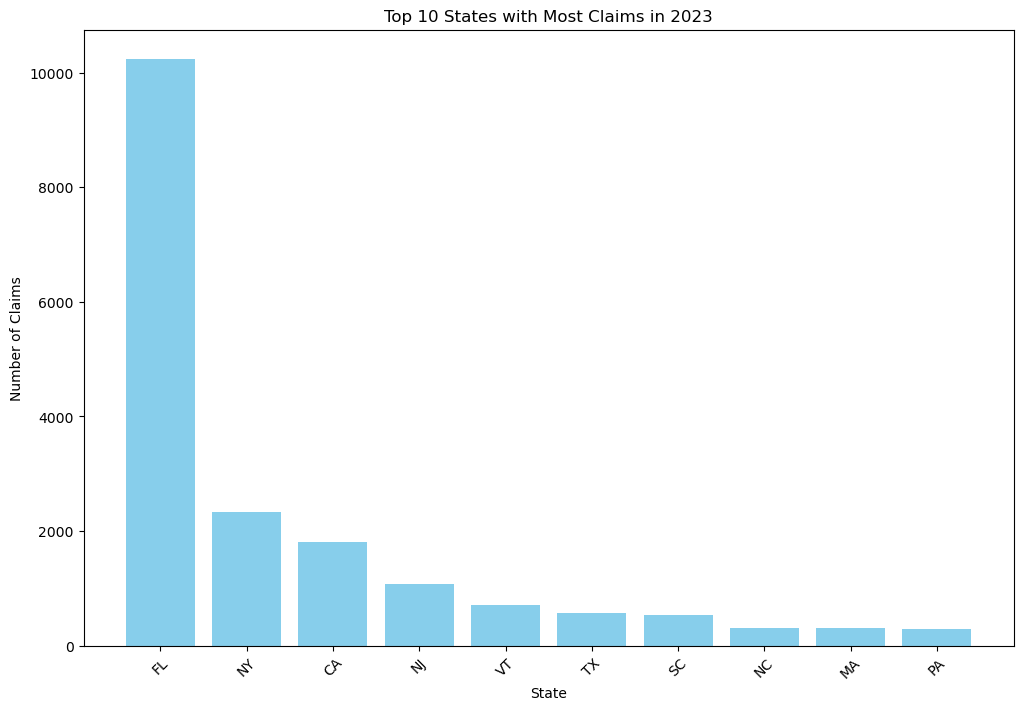

In [7]:
import logging
import matplotlib.pyplot as plt

logging.basicConfig(filename='top_10_states_claims_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def visualize_top_states(top_10_states):
    states = [item[0] for item in top_10_states]  
    counts = [item[1] for item in top_10_states] 

    plt.figure(figsize=(12, 8)) 
    plt.bar(states, counts, color='skyblue')  
    plt.xlabel('State')  
    plt.ylabel('Number of Claims') 
    plt.title('Top 10 States with Most Claims in 2023')
    plt.xticks(rotation=45)
    plt.show() 

    #Top 10 states with most claims
    logging.info("Top 10 States with Most Flood Insurance Claims in 2023:")
    for state, count in top_10_states:
        logging.info(f"{state}: {count} claims")

visualize_top_states(top_10_states)

## Claims By State and Year

The following code snippet fetches and processes claims data for a specified year of loss. In this example we select the year 2023. 

In [8]:
import requests
import pandas as pd

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000

def fetch_claims_data(year_of_loss):
    claims_data = []
    skip_records = 0
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss}&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            claims_data.extend(data["FimaNfipClaims"])
            if len(data['FimaNfipClaims']) < record_limit:
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            break
    return claims_data

def process_claims_data(claims_data, year_of_loss):
    # Convert list of dictionaries to DataFrame
    claims_df = pd.DataFrame(claims_data)

    # Convert payment amounts to numeric type
    claims_df['totalPayments'] = pd.to_numeric(claims_df['amountPaidOnBuildingClaim'], errors='coerce') + \
                                 pd.to_numeric(claims_df['amountPaidOnContentsClaim'], errors='coerce') + \
                                 pd.to_numeric(claims_df['amountPaidOnIncreasedCostOfComplianceClaim'], errors='coerce')

    # Group by 'state' and calculate sum, mean, and median
    state_summary = claims_df.groupby('state').agg(
        Total_Payments=('totalPayments', 'sum'),
        Mean_Payment=('totalPayments', 'mean'),
        Median_Payment=('totalPayments', 'median'),
        Claims_Count=('state', 'count'),
        Claims_With_Payment=('totalPayments', lambda x: (x > 0).sum())
    ).reset_index()

    # Format the 'Total_Payments' as currency
    state_summary['Total_Payments'] = state_summary['Total_Payments'].apply(lambda x: f"${x:,.2f}")
    state_summary['Mean_Payment'] = state_summary['Mean_Payment'].apply(lambda x: f"${x:,.2f}")
    state_summary['Median_Payment'] = state_summary['Median_Payment'].apply(lambda x: f"${x:,.2f}")

    state_summary.rename(columns={'state': 'State', 'Claims_Count': f'Claims_in_{year_of_loss}'}, inplace=True)

    return state_summary

# Example usage
year_of_loss = 2023
claims_data = fetch_claims_data(year_of_loss)
state_summary = process_claims_data(claims_data, year_of_loss)

# Displaying the DataFrame
display(state_summary)

,State,Total_Payments,Mean_Payment,Median_Payment,Claims_in_2023,Claims_With_Payment
0,AK,"$1,183,030.53","$69,590.03","$21,597.16",19,12
1,AL,"$2,570,033.03","$46,727.87","$11,690.11",63,37
2,AR,"$2,579,921.02","$32,657.23","$14,505.21",85,57
3,AZ,"$1,006,823.07","$23,971.98","$7,217.99",60,25
4,CA,"$62,493,432.36","$41,913.77","$12,971.60",1806,1133
5,CO,"$1,065,428.40","$12,534.45","$4,423.06",132,63
6,CT,"$2,447,064.79","$20,915.08","$6,877.45",129,90
7,DC,"$715,797.21","$102,256.74","$3,071.48",12,6
8,DE,"$272,414.48","$8,254.98","$3,120.12",37,24
9,FL,"$651,606,796.40","$66,865.76","$52,181.18",10240,8506


<div class="alert alert-block alert-info">
    <b>Tip:</b> The above example retrieves all the fields in the Claims dataset when only a few are needed. Use the \$select argument to specify a comma-delimited list of the fields you want to return. This will result in significantly faster downloads and use less memory - essentally improving performance. 
</div>

### Export the table to a CSV file

We can save the results from our table to a comma separated value (CSV) table. 

In [9]:
# Export the data to a CSV file
csv_file_path = 'state_summary_with_total_mean_median.csv'
state_summary.to_csv(csv_file_path, index=False)
print(f"DataFrame exported to CSV at: {csv_file_path}")

DataFrame exported to CSV at: state_summary_with_total_mean_median.csv


## Top 10 Communities with the Most Claims in a Given Year

Next, we'll turn our attention to a single state, **Utah**, and filter for the top 10 communities in the state between 2017 and 2023. 

In [10]:
import requests
from collections import Counter

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000

def fetch_num_claims_for_range(start_year, end_year, state_of_interest):
    """Fetches claims data for a given range of years and a specific state."""
    claims_data = []
    for year_of_loss in range(start_year, end_year + 1):
        skip_records = 0
        while True:
            url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state_of_interest}'&$top={record_limit}&$skip={skip_records}&$format=json"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                claims_data.extend(data["FimaNfipClaims"])
                if len(data['FimaNfipClaims']) < record_limit:
                    break
                skip_records += record_limit
            else:
                print(f"Failed to fetch data for {year_of_loss}: HTTP {response.status_code}")
                break
    return claims_data

def aggregate_claims_by_community(claims_data):
    """Aggregates claims by community from the fetched claims data."""
    community_counts = Counter()
    for claim in claims_data:
        communityID = claim.get('nfipCommunityName')
        if communityID:
            community_counts[communityID] += 1
    return community_counts

start_year = 2017
end_year = 2023
state_of_interest = "UT"  
claims_data = fetch_num_claims_for_range(start_year, end_year, state_of_interest)

# Aggregates claims by community across all fetched years
community_counts = aggregate_claims_by_community(claims_data)

# Determines the top 10 communities with the most claims
top_10_communities = community_counts.most_common(10)

print(f"Top 10 Communities with Most Claims from {start_year} to {end_year} in {state_of_interest}:")
for community, count in top_10_communities:
    print(f"{community}: {count} claims")


Top 10 Communities with Most Claims from 2017 to 2023 in UT:
SALT LAKE COUNTY *: 9 claims
SALT LAKE CITY, CITY OF: 8 claims
ST. GEORGE, CITY OF: 7 claims
WEBER COUNTY *: 7 claims
SUMMIT COUNTY *: 7 claims
MOAB, CITY OF: 7 claims
IRON COUNTY *: 6 claims
UTAH COUNTY *: 6 claims
DRAPER, CITY OF: 6 claims
KAYSVILLE, CITY OF: 5 claims


<div class="alert alert-block alert-warning">
    <b>Note:</b> The above example does not count records that have no community assigned. The code could be modified to count these null community examples providing a better picture of the data.
</div>

<div class="alert alert-block alert-info">
    <b>Tip:</b> Although the city field is currently unavailable, the community identifier and name can sometimes be used as a proxy for the city. 
</div>

## Yearly Claims Trends for Top Communities

Next we will plot the top 5 communities with claims over time (2017 - 2023).

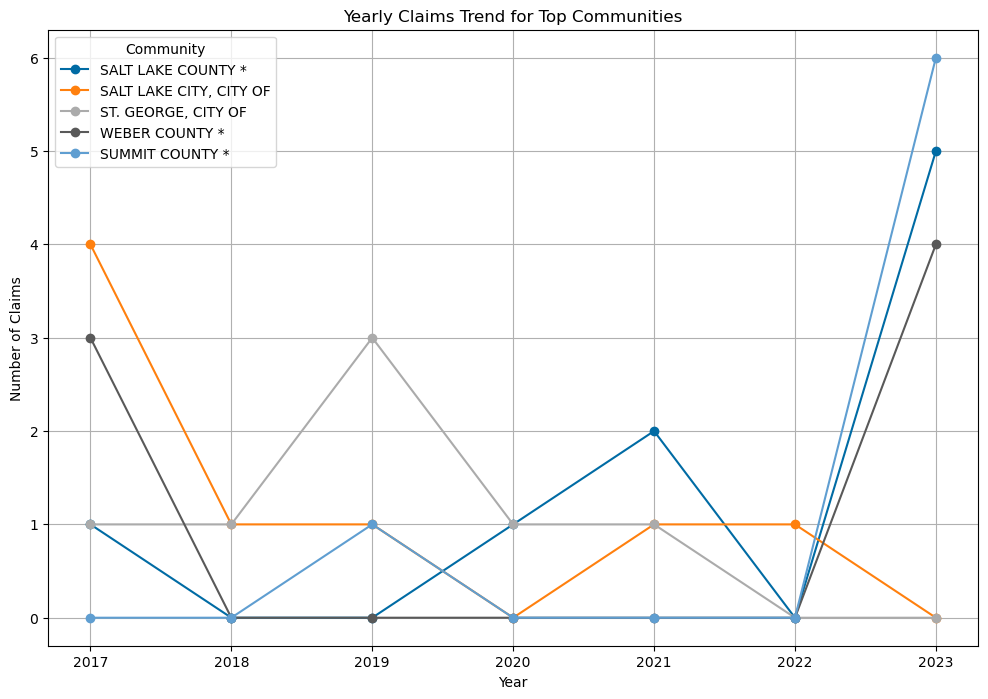

In [11]:
# Import libraries to streamline tasks involving data organization, aggregation, and counting
from collections import defaultdict, Counter

def fetch_data(start_year, end_year, state_of_interest):
    """Fetch claims data and aggregate by community and year."""
    data_dict = defaultdict(lambda: defaultdict(lambda: {'claimsCount':0, 'netBuilding':0, 'netContent':0, 'netICC':0}))
    for year_of_loss in range(start_year, end_year + 1):
        skip_records = 0
        while True:
            url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state_of_interest}'&$top={record_limit}&$skip={skip_records}&$format=json"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                for claim in data["FimaNfipClaims"]:
                    communityID = claim.get('nfipCommunityName')
                    if communityID:
                        data_dict[year_of_loss][communityID]['claimsCount'] += 1
                        data_dict[year_of_loss][communityID]['netBuilding'] += int(claim.get('netBuildingPaymentAmount', 0))
                        data_dict[year_of_loss][communityID]['netContent'] += int(claim.get('netContentsPaymentAmount', 0))
                        data_dict[year_of_loss][communityID]['netICC'] += int(claim.get('IncreasedCostOfComplianceClaim', 0))
                if len(data['FimaNfipClaims']) < record_limit:
                    break
                skip_records += record_limit
            else:
                print(f"Failed to fetch data for {year_of_loss}: HTTP {response.status_code}")
                break
    return data_dict

# Corrected top_communities function to work with the new data_dict structure
def top_communities(data_dict, top_number):
    """Identify top # of communities based on total claims over all years."""
    total_claims_by_community = Counter()
    for year_data in data_dict.values():
        for community, details in year_data.items():
            total_claims_by_community[community] += details['claimsCount']
    return total_claims_by_community.most_common(top_number)

# Assuming year_community_claims variable correctly stores the fetched and aggregated data
year_community_claims = fetch_data(start_year, end_year, state_of_interest)
top_community_data = top_communities(year_community_claims, 5)  # Assuming this should fetch top 5 communities

def visualize_community_trends(data_dict, top_communities_info):
    """Display yearly trend of claims for the top communities and, if only one community is selected, also display total payment amounts."""
    years = sorted(data_dict.keys())
    communities = [community for community, _ in top_communities_info]

    # Create a figure for the claims count trends
    plt.figure(figsize=(12, 8))
    for community in communities:
        yearly_counts = [data_dict[year][community]['claimsCount'] if community in data_dict[year] else 0 for year in years]
        plt.plot(years, yearly_counts, marker='o', label=community)

    plt.xlabel('Year')
    plt.ylabel('Number of Claims')
    plt.title('Yearly Claims Trend for Top Communities')
    plt.legend(title='Community')
    plt.grid(True)
    plt.xticks(years)
    plt.show()

    # If only one community is selected, also show total payment amounts for each year
    if len(communities) == 1:
        community = communities[0]
        total_payments = [sum([data_dict[year][community]['netBuilding'],
                               data_dict[year][community]['netContent'],
                               data_dict[year][community]['netICC']]) if community in data_dict[year] else 0 for year in years]

        plt.figure(figsize=(12, 8))
        plt.bar(years, total_payments, color='skyblue', label='Total Payments')
        plt.xlabel('Year')
        plt.ylabel('Total Payment Amount ($)')
        plt.title(f'Total Payment Amount for {community}')
        plt.legend()
        plt.xticks(years)
        plt.show()

start_year = 2017
end_year = 2023
state_of_interest = "UT"
data_dict = fetch_data(start_year, end_year, state_of_interest)

top_community_data_multiple = top_communities(data_dict, 5)  # For multiple communities
top_community_data_single = top_communities(data_dict, 1)  

visualize_community_trends(data_dict, top_community_data_multiple)  # For multiple communities

We can also plot two variables on a dual-axis plot. We will select claims counts and total payments for the following chart.

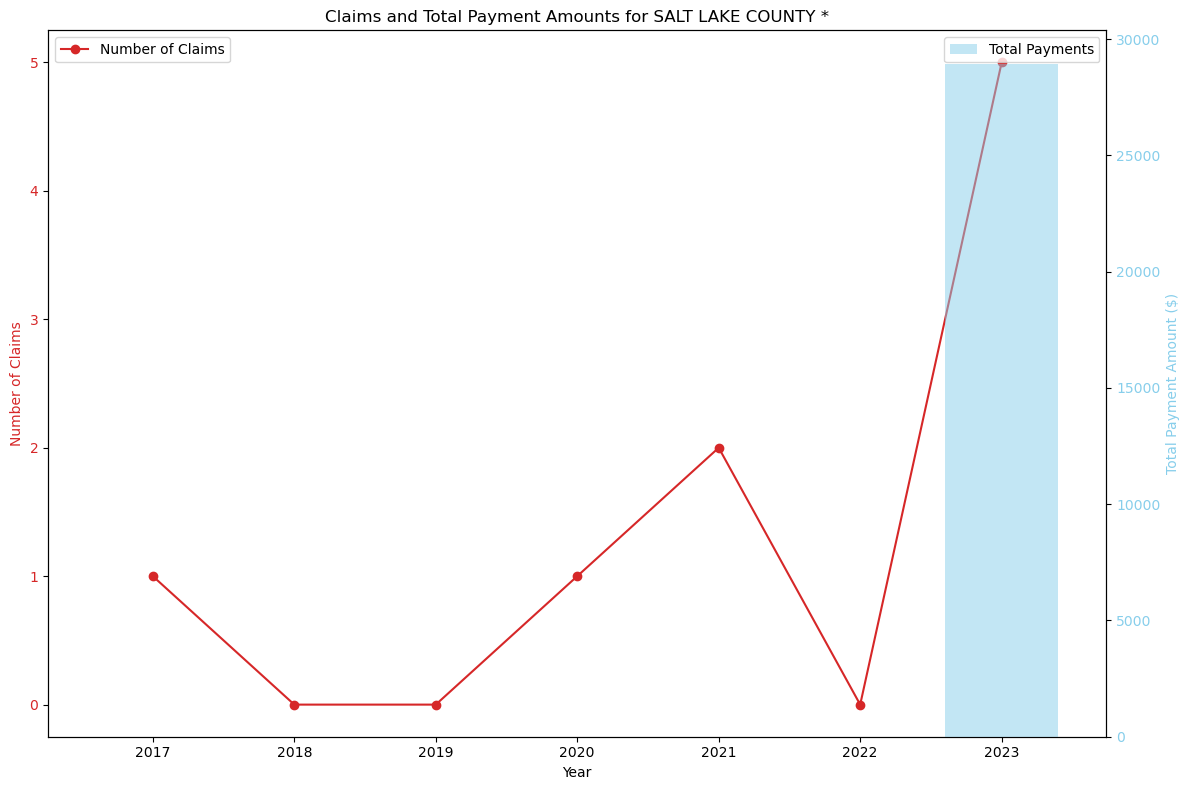

In [12]:
def visualize_single_community_trends(data_dict, community_info):
    """Displays yearly trend of claims and total payment amounts for a single community."""
    community = community_info[0][0]  
    years = sorted(data_dict.keys())

    yearly_counts = [data_dict[year][community]['claimsCount'] if community in data_dict[year] else 0 for year in years]
    total_payments = [data_dict[year][community]['netBuilding'] +
                      data_dict[year][community]['netContent'] +
                      data_dict[year][community]['netICC'] if community in data_dict[year] else 0 for year in years]

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot the line graph for the number of claims
    ax1.plot(years, yearly_counts, marker='o', color='tab:red', label='Number of Claims')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Claims', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xticks(years)
    ax1.legend(loc='upper left')

    # Plot the bar graph for total payment amounts
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.bar(years, total_payments, color='skyblue', alpha=0.5, label='Total Payments')
    ax2.set_ylabel('Total Payment Amount ($)', color='skyblue')
    ax2.tick_params(axis='y', labelcolor='skyblue')
    ax2.legend(loc='upper right')

    plt.title(f'Claims and Total Payment Amounts for {community}')
    fig.tight_layout() 
    plt.show()
    
visualize_single_community_trends(data_dict, top_community_data_single)  # For the top 1 community

## Occupancy Type Table

We can also group things by categorical variables such as "occupancy type". The following table displays the number of claims in Utah by occupancy type. The following table aggregates claims counts for Utah in 2023 by occupancy type code.

In [13]:
import requests
import pandas as pd
import numpy as np

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000

def fetch_claims_data(year_of_loss, state_of_interest):
    """ Fetches claims data for a given year. """
    claims_data = []
    skip_records = 0
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state_of_interest}'&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            claims_data.extend(data["FimaNfipClaims"])
            if len(data['FimaNfipClaims']) < record_limit:
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data for {year_of_loss}: HTTP {response.status_code}")
            break
    return pd.DataFrame(claims_data)

def process_claims_data(claims_data):
    """ Process claims data to compute total payments and map occupancy types. """
    claims_data['totalPayments'] = claims_data[['netBuildingPaymentAmount', 'netContentsPaymentAmount', 'netIccPaymentAmount']].fillna(0).astype(float).sum(axis=1)

    # Use float to preserve NaNs, then drop rows with NaN in 'occupancyType'
    claims_data['occupancyType'] = claims_data['occupancyType'].astype(float)
    claims_data.dropna(subset=['occupancyType'], inplace=True)
    claims_data['occupancyType'] = claims_data['occupancyType'].astype(int)  # Convert to int after dropping NaNs

    occupancy_type_descriptions = {
        1: "Single family residence",
        2: "2 to 4 unit residential building",
        3: "Residential building with more than 4 units",
        4: "Non-residential building",
        6: "Non Residential - Business",
        11: "Single-family residential building with the exception of a mobile home or a single residential unit within a multi unit building",
        12: "A residential non-condo building with 2, 3, or 4 units seeking insurance on all units",
        13: "A residential non-condo building with 5 or more units seeking insurance on all units",
        14: "Residential mobile/manufactured home",
        15: "Residential condo association seeking coverage on a building with one or more units",
        16: "Single residential unit within a multi-unit building",
        17: "Non-residential mobile/manufactured home",
        18: "A non-residential building",
        19: "A non-residential unit within a multi-unit building"
    }
    claims_data['Occupancy_Description'] = claims_data['occupancyType'].map(occupancy_type_descriptions)

    # Group and aggregate
    occupancy_type_stats = claims_data.groupby(['occupancyType', 'Occupancy_Description']).agg(
        Claim_Count=('occupancyType', 'count'),
        Claim_Payment_Amount=('totalPayments', 'sum')
    ).reset_index()

    # Format 'Claim_Payment_Amount' as currency
    occupancy_type_stats['Claim_Payment_Amount'] = occupancy_type_stats['Claim_Payment_Amount'].apply(lambda x: f"${x:,.2f}")

    return occupancy_type_stats

state_of_interest = 'UT'
year_of_loss = 2023
claims_data = fetch_claims_data(year_of_loss, state_of_interest)
occupancy_type_stats = process_claims_data(claims_data)

display(occupancy_type_stats)


,occupancyType,Occupancy_Description,Claim_Count,Claim_Payment_Amount
0,1,Single family residence,1,$310.87
1,11,Single-family residential building with the ex...,53,"$351,977.40"
2,13,A residential non-condo building with 5 or mor...,1,$0.00
3,14,Residential mobile/manufactured home,1,$0.00
4,16,Single residential unit within a multi-unit bu...,3,"$7,850.99"
5,18,A non-residential building,1,$0.00


<div class="alert alert-block alert-warning">
    <b>Note:</b> Two-digit occupancy type codes are associated with Risk Rating 2.0 policies, whereas the single-digit codes are associated with legacy rated policies.
</div>

## Cause of Damage for Claims per State and Year

Below is an aggregation of net building and contents payments amounts by cause of damage in the state of Utah in 2023.

In [14]:
import requests
import pandas as pd
from collections import defaultdict

# Base URL and setup for the FimaNfipClaims endpoint
base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000

# Cause of damage descriptions
cause_of_damage_descriptions = {
    '0': 'Other causes',
    '1': 'Tidal water overflow',
    '2': 'Stream, river, or lake overflow',
    '3': 'Alluvial fan overflow',
    '4': 'Accumulation of rainfall or snowmelt',
    '7': 'Erosion-demolition',
    '8': 'Erosion-removal',
    '9': 'Earth movement, landslide, land subsidence, sinkholes, etc.',
    'A': 'Closed basin lake',
    'B': 'Expedited claim handling process without site inspection',
    'C': 'Expedited claim handling process follow-up site inspection',
    'D': 'Expedited claim handling process by Adjusting Process Pilot Program (Remote Adjustment)'
}

def fetch_data(year_of_loss, state_of_interest):
    data_dict = defaultdict(lambda: {'count': 0, 'netBuilding': 0, 'netContent': 0})
    total_records = get_total_record_count(year_of_loss, state_of_interest)
    total_calls = (total_records // record_limit) + (total_records % record_limit > 0)

    for call_number in range(total_calls):
        skip_records = call_number * record_limit
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state_of_interest}'&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            for record in data['FimaNfipClaims']:
                cause_of_damage = record.get('causeOfDamage')
                building_value = int(record.get('netBuildingPaymentAmount', 0))
                content_value = int(record.get('netContentsPaymentAmount', 0))
                if cause_of_damage:
                    cause_of_damage = cause_of_damage_descriptions.get(cause_of_damage, cause_of_damage)  # Map code to description
                    data_dict[cause_of_damage]['count'] += 1
                    data_dict[cause_of_damage]['netBuilding'] += building_value
                    data_dict[cause_of_damage]['netContent'] += content_value
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            break

    return pd.DataFrame(data_dict).T.reset_index().rename(columns={'index': 'Cause of Damage'})

def get_total_record_count(year_of_loss, state):
    url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state}'&$top=1&$inlinecount=allpages"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return int(data['metadata']['count'])
    else:
        print(f"Failed to get total record count: HTTP {response.status_code}")
        return 0

# Usage example
if __name__ == "__main__":
    data_df = fetch_data(2023, "UT")
data_df

,Cause of Damage,count,netBuilding,netContent
0,Other causes,17,14302,0
1,"Stream, river, or lake overflow",4,26891,0
2,Accumulation of rainfall or snowmelt,35,298556,12521
3,Tidal water overflow,3,7850,0


## Claims by Event

There are two ways in which FEMA tracks NFIP flood events. Prior to 2020, the NFIP used the Flood Insurance Claims Office (FICO) number system to assign tracking numbers to flood events. Starting in 2020, the Event Designation Number (EDN) system was implemented. Both data points are provided on OpenFEMA. 

In this example, we will review claims for a FICO event in Utah (#514).

In [15]:
import requests
import pandas as pd

def fetch_data_by_fico_number(fico_number):
    base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
    params = {
        "$filter": f"ficoNumber eq {fico_number}",
        "$format": "json",
        "$top": 10000 
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        claims = data.get("FimaNfipClaims", [])
        if claims:
            return pd.DataFrame(claims)
        else:
            return pd.DataFrame()
    else:
        raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

fico_number = 514
claims_data = fetch_data_by_fico_number(fico_number)

# Calculate total net payments
claims_data['totalNetPayment'] = (
    pd.to_numeric(claims_data['netBuildingPaymentAmount'], errors='coerce') +
    pd.to_numeric(claims_data['netContentsPaymentAmount'], errors='coerce') +
    pd.to_numeric(claims_data['netIccPaymentAmount'], errors='coerce')
)

# Descriptive statistics
number_of_claims = len(claims_data)
total_net_payments = claims_data['totalNetPayment'].sum()
mean_net_payment = claims_data['totalNetPayment'].mean()
median_net_payment = claims_data['totalNetPayment'].median()


print(f"Number of claims for FICO #{fico_number}: {number_of_claims}")
print(f"Total net payments: ${total_net_payments:,.2f}")
print(f"Mean net payment: ${mean_net_payment:,.2f}")
print(f"Median net payment: ${median_net_payment:,.2f}")

Number of claims for FICO #514: 52
Total net payments: $568,990.39
Mean net payment: $10,942.12
Median net payment: $1,782.20


# Claims in/out SFHA

We might also want to calculate the number of claims located inside and outside of the Special Flood Hazard Area (SFHA). The code snippet below defines a function for the the SFHA which aliases the flood zone field before aggregating a count of claims in each grouping.

<div class="alert alert-block alert-info">
    <b>Tip:</b> The Special Flood Hazard Area (SFHA) is generally referred to as the area that will be inundated by the flood event having a 1-percent chance of being equaled or exceeded in any given year. The SFHA is identified by flood zones starting with the letter 'A' or 'V'.  
</div>

In [16]:
import requests
import pandas as pd
import numpy as np

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000

def fetch_claims_data(year_of_loss, state_of_interest):
    """ Fetches claims data for a given year. """
    claims_data = []
    skip_records = 0
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss} and state eq '{state_of_interest}'&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            claims_data.extend(data["FimaNfipClaims"])
            if len(data['FimaNfipClaims']) < record_limit:
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data for {year_of_loss}: HTTP {response.status_code}")
            break
    return pd.DataFrame(claims_data)

state_of_interest = 'UT'
year_of_loss = 2023
claims_data = fetch_claims_data(year_of_loss, state_of_interest)

def sfha(flood_zone):
    if pd.isna(flood_zone) or flood_zone == '':
        return 'Unknown'
    #first_char = flood_zone[0].upper()  # Get the first character and convert to uppercase
    if flood_zone[0].upper() in 'AV':
        return 'SFHA'  # Alias for vowel
    else:
        return 'Non-SFHA'  # Alias for consonant

claims_data['SFHA'] = claims_data['ratedFloodZone'].apply(sfha)    

fz_summary = claims_data.groupby(claims_data['SFHA']).agg(ClaimsCount=('id', 'count')).reset_index()
display(fz_summary)

,SFHA,ClaimsCount
0,Non-SFHA,52
1,SFHA,8


## Map of Claims

Perhaps the best way to visualize spatial data is through a map. The following examples showcase potential visualizations using OpenFEMA and the *cenpy* and *geopandas* packages. 

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

import requests
from collections import Counter

base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"
record_limit = 10000 
year_of_loss = 2023

def fetch_num_claims(year_of_loss):
    claims_data = []
    skip_records = 0
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss}&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url) 
        if response.status_code == 200:  
            data = response.json()
            claims_data.extend(data["FimaNfipClaims"])
            if len(data['FimaNfipClaims']) < record_limit:
                # Break the loop if we have fetched all available records
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            break
    return claims_data 
def aggregate_claims_by_state(claims_data):
    state_counts = Counter()
    for claim in claims_data:
        state = claim.get('state')
        if state:
            state_counts[state] += 1
    return state_counts

claims_data = fetch_num_claims(year_of_loss)

# Aggregate claims by state
state_counts = aggregate_claims_by_state(claims_data)

state_counts_df = pd.DataFrame(list(state_counts.items()), columns=['State', 'Claims'])
#state_counts_df

Next, we'll define two functions. The first will fetch claim data based on year of loss. The second will use that data subset to aggregate by county and count claims. 

In [18]:
import cenpy as cp
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pandas as pd

def fetch_num_claims(year_of_loss, base_url="https://www.fema.gov/api/open/v2/FimaNfipClaims", record_limit=1000):
    claims_data = []
    skip_records = 0
    
    while True:
        url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss}&$top={record_limit}&$skip={skip_records}&$format=json"
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            claims = data.get("FimaNfipClaims", [])
            claims_data.extend(claims)
            
            if len(claims) < record_limit:
                break
            skip_records += record_limit
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            break
            
    return pd.DataFrame(claims_data)

def aggregate_claims_by_county(claims_data):
    claims_data['countyCode'] = claims_data['countyCode'].astype(str).str.zfill(5)
    county_claims = claims_data.groupby('countyCode').size().reset_index(name='Claims')
    return county_claims

C:\Users\mmatsuya\AppData\Roaming\Python\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


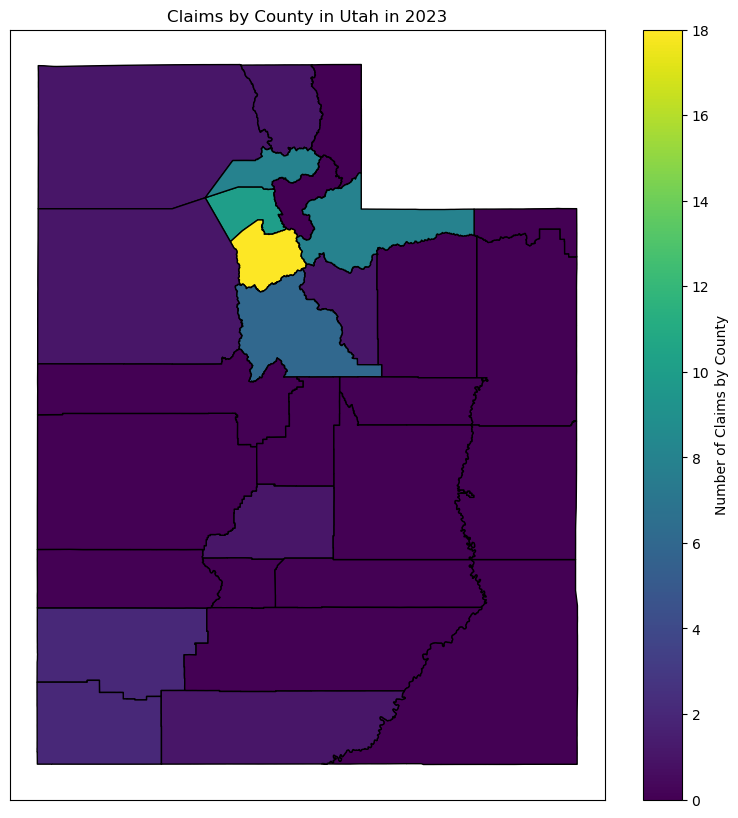

In [19]:
# Access ACS data product
acs = cp.products.ACS(2019)

variables = ['GEOID', 'NAME'] 

year_of_loss = 2023
claims_data_df = fetch_num_claims(year_of_loss)
county_claims = aggregate_claims_by_county(claims_data_df)

county_boundaries = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)
county_claims['countyCode'] = county_claims['countyCode'].astype(str)

# Merge the geographic data with the claims data
merged_data = utah_counties_geo.merge(county_claims, left_on='GEOID', right_on='countyCode', how='left')

merged_data['Claims'] = merged_data['Claims'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='Claims', ax=ax, legend=True, 
         edgecolor='black',  # Highlight county boundaries
         vmin=0, vmax=gdf['Claims'].max(),  # Normalize the color scale
         legend_kwds={'label': 'Number of Claims by County'})
plt.title('Claims by County in Utah in 2023')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

Lastly, we can plot the entire continental US displaying log claims (for better visualization purposes). 

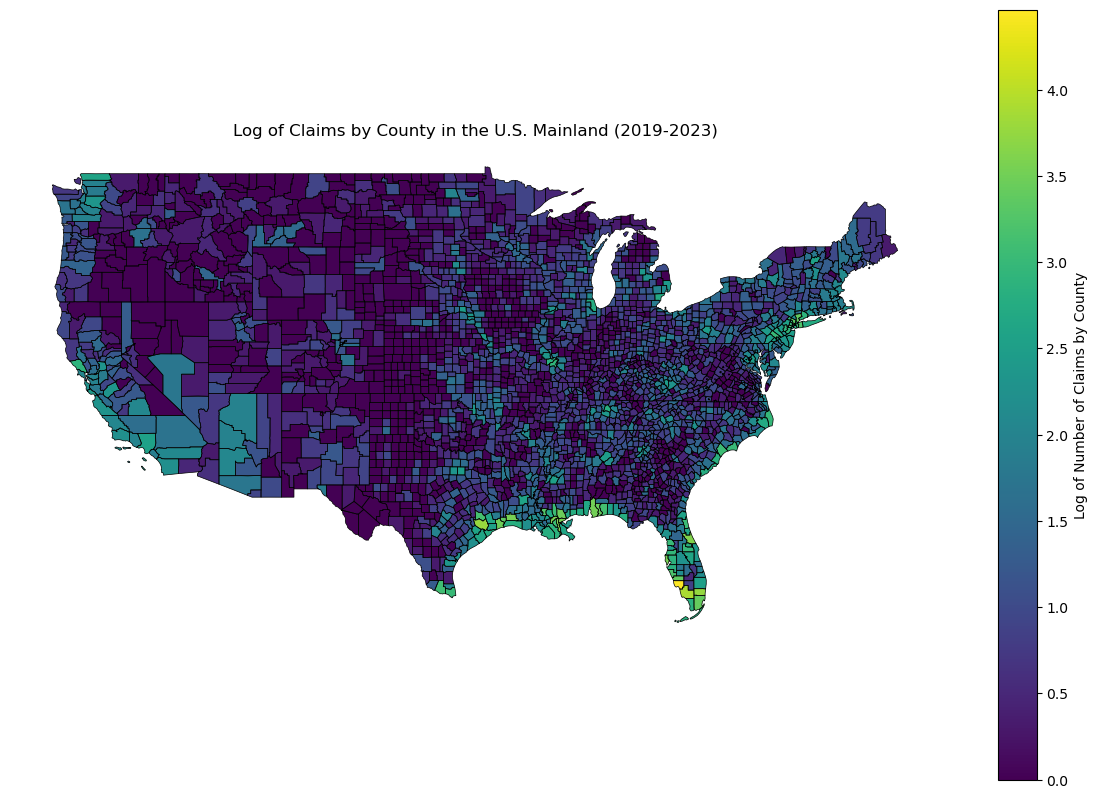

In [20]:
import cenpy as cp
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np

# Function to fetch and aggregate claims data by year
def fetch_and_aggregate_claims(start_year, end_year, base_url="https://www.fema.gov/api/open/v2/FimaNfipClaims", record_limit=1000):
    all_claims_data = pd.DataFrame()
    
    for year_of_loss in range(start_year, end_year + 1):
        claims_data = []
        skip_records = 0
        
        while True:
            url = f"{base_url}?$filter=yearOfLoss eq {year_of_loss}&$top={record_limit}&$skip={skip_records}&$format=json"
            response = requests.get(url)
            
            if response.status_code == 200:
                data = response.json()
                claims = data.get("FimaNfipClaims", [])
                claims_data.extend(claims)
                
                if len(claims) < record_limit:
                    break
                skip_records += record_limit
            else:
                print(f"Failed to fetch data for {year_of_loss}: HTTP {response.status_code}")
                break
                
        yearly_claims_df = pd.DataFrame(claims_data)
        if not yearly_claims_df.empty:
            yearly_claims_df['yearOfLoss'] = year_of_loss
            all_claims_data = pd.concat([all_claims_data, yearly_claims_df], ignore_index=True)
    
    return all_claims_data

# Aggregate function
def aggregate_claims_by_county(claims_data):
    claims_data['countyCode'] = claims_data['countyCode'].astype(str).str.zfill(5)
    county_claims = claims_data.groupby('countyCode').size().reset_index(name='Claims')
    return county_claims

# Fetch claims data from the past 5 years and aggregate
claims_data_df = fetch_and_aggregate_claims(2019, 2023)
county_claims = aggregate_claims_by_county(claims_data_df)

# Access ACS data product
acs = cp.products.ACS(2019)

# URL to fetch county geometries (to replace the direct cenpy call with all U.S. mainland counties)
url = "https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_20m.zip"
county_boundaries = gpd.read_file(url)
county_boundaries = county_boundaries[~county_boundaries['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])]  # Exclude non-mainland

# Ensure GEOID is a string for merging
county_boundaries['GEOID'] = county_boundaries['GEOID'].astype(str)
county_claims['countyCode'] = county_claims['countyCode'].astype(str)

# Merge
merged_df = county_boundaries.merge(county_claims, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN with 0 in 'Claims'
merged_df['Claims'].fillna(0, inplace=True)
merged_df['ClaimsLog'] = np.log10(merged_df['Claims'] + 1)  # Apply log transformation

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
merged_df.plot(column='ClaimsLog', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'},
               legend_kwds={'label': 'Log of Number of Claims by County'})
county_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)  # Add county outlines
plt.title('Log of Claims by County in the U.S. Mainland (2019-2023)')
plt.axis('off')
plt.show()


<div class="alert alert-block alert-info">
    <b>Tip:</b> The above mapping examples retrieve data from the OpenFEMA API multiple times. If you need to perform various analysis on the same set of data, it is strongly advised that you first download the data and save it to a file - especially if it is a large amount of data. If your program crashes partway through, you will need to download data again.
</div>
<div class="alert alert-block alert-info">
    <b>Tip:</b> When downloading data to a file, specify your prefered file type using the \$format argument rather than converting within Python. OpenFEMA currently supports JSON, JSONA, JSONL, GeoJson (where applicable), CSV, and Parquet file formats. 
</div>

## Where to go Next
 - Review the NFIP Policies Demo Jupyter notebook
 - See the [OpenFEMA API Tutorials on GitHub](https://github.com/FEMA/openfema-samples) in the analysis-examples folder

## Other Resources
- [FloodSmart Reports](https://nfipservices.floodsmart.gov//reports-flood-insurance-data)
- [National Flood Insurance Program](https://www.fema.gov/flood-insurance)
- [OpenFEMA API Documentation](https://www.fema.gov/about/openfema/api)
- [US Census Python Library (cenpy)](https://pypi.org/project/cenpy/)

## Acknowledgements
Special thanks to Lilian Chiang, 2024 Virtual Student Federal Service (VSFS) intern, whose hard work and insights were crucial in creating this Jupyter notebook.